# Chapter 8: Support Vector Machines and Kernel Methods
This notebook provides practical "recipes" for text classification and multiclass classification problems. Each recipe includes explanations, code examples, visualizations, best practices, and common pitfalls when applicable. 

## Introduction to Text Processing
Text processing is a fundamental step in ML, especially crucial when dealing with natural language data. It is estimated that somewhere between 80% to 90% of data is unstructured data which includes text as well as other non-traditional data sources like images, video, audio, etc.  Like structured data, textual data often contains noise, irrelevant information, and varying formatting that can pose challenges for effective modeling. Effective preprocessing converts raw text into structured numerical data, enabling the application of machine learning algorithms. Let’s start by learning some of the basic scikit-learn tools for working with this type of data. We will also incorporate a few other Python libraries including Pandas and numPy.

### Getting ready
We'll prepare our environment by loading essential libraries and text data. Now that we are using text data rather than numeric data, we will utilize a built-in dataset from Python’s NLTK (Natural Language Tool Kit) library. Typically, we call a collection of text used in the context of modeling a corpus. This particular corpus is the movie_reviews dataset which contains 2,000 reviews categorized as either positive or negative.

In [2]:
# Load the libraries
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import movie_reviews
import matplotlib.pyplot as plt

# Download NLTK data if not already present (specifically, the movie_reviews corpus)
try:
    movie_reviews.sents()
except LookupError:
    nltk.download('movie_reviews')

# Load the dataset from NLTK movie_reviews corpus
documents = []
labels = []
for category in movie_reviews.categories():
    for fileid in movie_reviews.fileids(category):
        documents.append(movie_reviews.raw(fileid))
        labels.append(category)

# Convert labels to numerical (0 for 'neg', 1 for 'pos')
label_map = {label: i for i, label in enumerate(sorted(list(set(labels))))}
numerical_labels = [label_map[label] for label in labels]


# Split the data
# Using a smaller subset for demonstration purposes to speed up processing
# and reduce memory usage, as the full movie_reviews corpus is quite large.
# You can adjust subset_size or remove this sampling for full dataset usage.
subset_size = 500 # Using 500 samples for quicker demonstration
if len(documents) > subset_size:
    # Stratified sampling to maintain class proportions
    texts_subset, _, labels_subset, _ = train_test_split(
        documents, numerical_labels, train_size=subset_size, stratify=numerical_labels, random_state=2024
    )
else:
    texts_subset = documents
    labels_subset = numerical_labels

X_train, X_test, y_train, y_test = train_test_split(texts_subset, labels_subset, test_size=0.3, random_state=2024, stratify=labels_subset)

### How to do it...
First, we will transform raw text into a numerical representation using scikit-learn's `CountVectorizer()`.


In [3]:
# Instantiate and fit CountVectorizer() with stopword removal
vectorizer = CountVectorizer(stop_words='english')
X_train_vect = vectorizer.fit_transform(X_train)

# Transform the test data
X_test_vect = vectorizer.transform(X_test)

### How it works...
`CountVectorizer()` converts text data into a sparse matrix of token counts, where each row represents a document, and each column represents a unique token. In the context of text processing, a token can refer to a fundamental unit of text – a word, a sentence, a paragraph, or even an individual letter can all be treated as a token depending on the application. This numerical representation is suitable for training various machine learning models. The `CountVectorizer()` function counts the occurrences of all words (the default token unit in this case) within each document


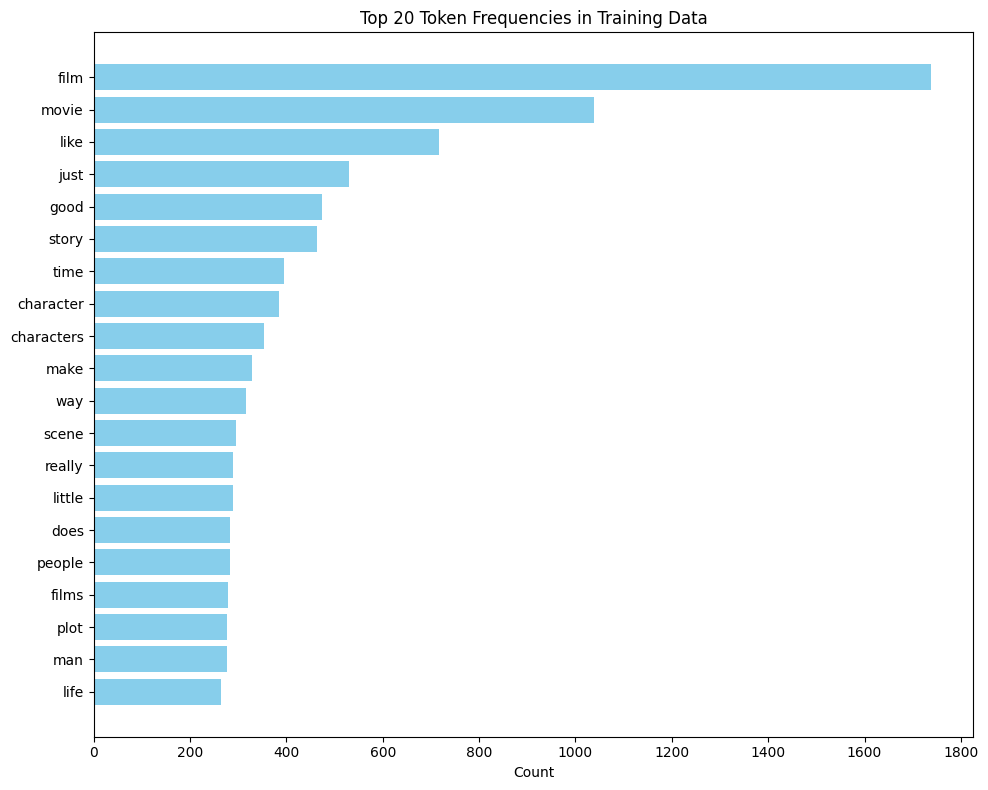

In [4]:
# Visualizing the token counts
feature_names = vectorizer.get_feature_names_out()
counts = X_train_vect.toarray().sum(axis=0)

top_n = 20 # Display top N features
num_features = len(feature_names) # Should be equal to len(counts)

if num_features > 0:
    # Sort features by count
    # argsort sorts in ascending order, [::-1] reverses it for descending
    sorted_indices = np.argsort(counts)[::-1] 
    
    actual_top_n = min(top_n, num_features)

    # Select top N features and their counts
    top_feature_names = feature_names[sorted_indices][:actual_top_n]
    top_counts = counts[sorted_indices][:actual_top_n]

    plt.figure(figsize=(10, 8)) # Adjusted figsize for better readability of N items
    plt.barh(top_feature_names, top_counts, color='skyblue')
    plt.xlabel('Count')
    plt.title(f'Top {actual_top_n} Token Frequencies in Training Data')

    # Dynamically set x-axis ticks using MaxNLocator for integer counts
    from matplotlib.ticker import MaxNLocator
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlim(left=0) # Ensure x-axis starts at 0

    ax.invert_yaxis() # Display the highest count at the top
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()
else: # num_features == 0
    # Fallback for no features (e.g., if CountVectorizer found no words)
    plt.figure(figsize=(10,6)) # Use original figsize for this fallback
    plt.text(0.5, 0.5, 'No features to display.', ha='center', va='center')
    plt.title('Token Frequency in Training Data')
    plt.xticks([]) # No x-ticks
    plt.yticks([]) # No y-ticks
    plt.show()


## Text Vectorization Techniques
Text vectorization techniques transform raw text into numerical representations, enabling ML algorithms to effectively analyze textual data. Techniques such as Bag of Words (BoW), TF-IDF, and word embeddings offer different approaches for capturing textual features and semantic meaning. Keep in mind, however, that even before text vectorization begins, a computer still must have a way to represent a letter in the first place. This is typically done using ASCII or Unicode encodings as an initial way to represent and store text in computer memory.

### Getting ready
We'll load necessary libraries and prepare textual data for vectorization. This time we will use the `reuters` corpus from NLTK. It contains 10,788 news documents and approximately 1.3 million words with over 90 possible categories for classification. We will just classify based on the first category for simplicity.


In [5]:
# Load the libraries
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import reuters
import matplotlib.pyplot as plt

# Download the Reuters corpus if not already downloaded
try:
    reuters.fileids()
except LookupError:
    nltk.download('reuters')

# Load the dataset from NLTK Reuters corpus
documents = reuters.fileids()
texts = [reuters.raw(doc_id) for doc_id in documents]

labels = [reuters.categories(doc_id)[0] for doc_id in documents] # Using the first category as the label for simplicity

# Split the data
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.5, random_state=2024)

### How to do it...
We'll demonstrate text vectorization using three common techniques: BoW, TF-IDF, and briefly discuss word embeddings.


In [6]:
# Bag of Words (BoW)
# Instantiate and fit CountVectorizer()
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

# TF-IDF Vectorization 
# Instantiate and fit TfidfVectorizer()
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

### How it works...
- **Bag of Words (BoW)** represents texts as frequency counts of individual words, disregarding word order and grammar.
- **TF-IDF** adjusts word frequencies by considering their rarity across all documents, assigning higher weights to distinctive terms. This technique is a little more involved than BoW and allows the classification of documents based on the occurrence of words much more efficiently. 


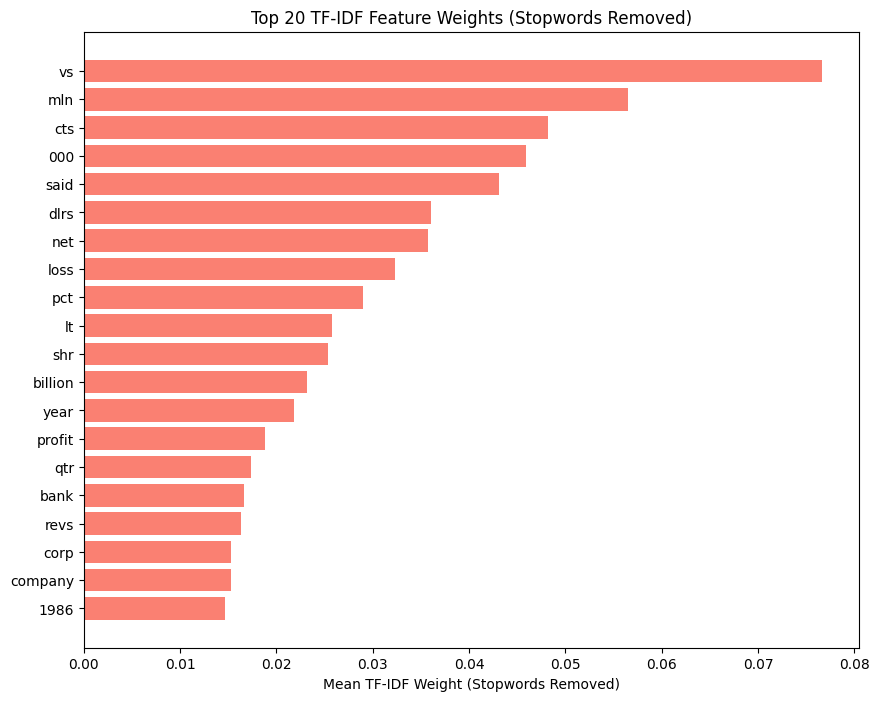

In [7]:
# Visualizing top 20 TF-IDF feature weights
# Create a TfidfVectorizer instance with English stop words removed
vis_tfidf_vectorizer = TfidfVectorizer(stop_words='english')
vis_X_train_tfidf = vis_tfidf_vectorizer.fit_transform(X_train)

# Get feature names and their mean TF-IDF weights from this new vectorization
feature_names = vis_tfidf_vectorizer.get_feature_names_out()
tfidf_means = vis_X_train_tfidf.toarray().mean(axis=0)

# Number of top terms to display
N = 20

# Ensure N is not greater than the number of available features
if len(feature_names) < N:
    N = len(feature_names)

# Get indices of the N largest TF-IDF means.
# np.argsort sorts in ascending order, so we take the last N indices.
# These indices will correspond to the N features with the highest TF-IDF scores,
# sorted from the Nth highest to the 1st highest (suitable for plt.barh to plot highest at top).
if N > 0 : # Proceed only if there are features to plot
    sorted_indices_ascending = np.argsort(tfidf_means)
    top_n_plotting_indices = sorted_indices_ascending[-N:]

    # Select the top N feature names and their TF-IDF means using these indices
    plot_feature_names = feature_names[top_n_plotting_indices]
    plot_tfidf_means = tfidf_means[top_n_plotting_indices]

    # Create the plot
    plt.figure(figsize=(10, 8)) # Adjusted figsize for better readability with 20 items
    plt.barh(plot_feature_names, plot_tfidf_means, color='salmon')
    plt.xlabel('Mean TF-IDF Weight (Stopwords Removed)')
    plt.title(f'Top {N} TF-IDF Feature Weights (Stopwords Removed)')
else: # Handle case with no features (e.g., if all features were stopwords or N=0)
    plt.figure(figsize=(10, 6)) # Original figsize for empty or minimal plot
    plt.barh([], []) # Plot empty data
    plt.xlabel('Mean TF-IDF Weight (Stopwords Removed)')
    plt.title('TF-IDF Feature Weights (No non-stopword features to display)')

plt.show()

## Feature Extraction from Text
Feature extraction from text is central for enhancing the performance of text classification models by identifying meaningful patterns and attributes within textual data. Techniques such as n-grams, part-of-speech (POS) tagging, and named entity recognition (NER) provide structured insights into textual content, significantly improving model accuracy and interpretability.

### Getting ready
We'll load the essential libraries and prepare the dataset for feature extraction. Here we will use the Brown Corpus also built-in to the NLTK library. It contains 500 sources categories by genre.


In [8]:
# Load the libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import brown
from nltk.util import ngrams as nltk_ngrams
import matplotlib.pyplot as plt
from collections import Counter 
import nltk 
from nltk.corpus import stopwords 

# Download necessary NLTK data (if not already present)
nltk.download('brown', quiet=True)
nltk.download('punkt', quiet=True)

# Load the dataset using the Brown corpus
texts = []
labels = []

# Define categories to use and number of sentences per category
# We'll use the first two categories from the Brown corpus for this example
# and take a small number of sentences from each.
# This will create a small dataset suitable for demonstration.
categories_to_use = brown.categories()[:2]  # Example: ['adventure', 'belles_lettres']
num_sents_per_category = 2  # Number of sentences to extract from each category

for i, category in enumerate(categories_to_use):
    # Get sentences for the current category
    # brown.sents() returns a list of sentences, where each sentence is a list of tokens.
    category_sents = brown.sents(categories=category)
    
    # Take the specified number of sentences from the beginning of the list
    for sent_tokens in category_sents[:num_sents_per_category]:
        texts.append(" ".join(sent_tokens))  # Join tokens to form a single string sentence
        labels.append(i)  # Assign a numerical label based on the category index

# At this point, 'texts' will contain 2*num_sents_per_category sentences,
# and 'labels' will contain corresponding integer labels (e.g., [0, 0, 1, 1] if num_sents_per_category=2)

# Split the data
# The dataset will have 4 samples if num_sents_per_category=2.
# test_size=0.5 will result in 2 training samples and 2 testing samples.
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.5, random_state=2024)


### How to do it...
We'll demonstrate extracting meaningful text features using n-grams, POS tagging, and NER.


In [9]:
# N-gram extraction
# Instantiate and fit CountVectorizer() with n-grams
ngram_vectorizer = CountVectorizer(ngram_range=(1,2))
X_train_ngram = ngram_vectorizer.fit_transform(X_train)
X_test_ngram = ngram_vectorizer.transform(X_test)

# Part-of-Speech (POS) Tagging using NLTK
nltk.download('punkt_tab', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

# POS tagging example
print("--- POS Tagging of Tokens and N-grams in Training Sentences ---")
for i, text in enumerate(X_train):
    print(f"\nOriginal Sentence {i+1}: \"{text}\"")
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens) # This returns a list of (token, TAG) tuples

    # Display tagged unigrams (individual tokens with their tags)
    print("  Tagged Tokens (Unigrams):")
    if pos_tags: # Check if list is not empty
        # Format as: token1/TAG1 token2/TAG2 ...
        unigram_str = " ".join([f"{token}/{tag}" for token, tag in pos_tags])
        print(f"    {unigram_str}")
    else:
        print("    (No tokens to tag)")

    # Display tagged bigrams
    # A bigram here means two consecutive (token, TAG) pairs
    if len(pos_tags) >= 2:
        print("  Tagged Bigrams:")
        # nltk_ngrams on pos_tags will yield tuples like ( (token1, TAG1), (token2, TAG2) )
        tagged_bigrams = list(nltk_ngrams(pos_tags, 2))
        for bigram_tuple in tagged_bigrams:
            # bigram_tuple is, e.g., (('The', 'DT'), ('quick', 'JJ'))
            # item1 is ('The', 'DT'), item2 is ('quick', 'JJ')
            item1, item2 = bigram_tuple 
            # Format as: token1/TAG1 token2/TAG2
            bigram_display_str = f"{item1[0]}/{item1[1]} {item2[0]}/{item2[1]}"
            print(f"    {bigram_display_str}")
    else:
        print("  (Not enough tagged tokens for bigrams)")
        
print("\n--- End of POS Tagging Display ---")

--- POS Tagging of Tokens and N-grams in Training Sentences ---

Original Sentence 1: "Northern liberals are the chief supporters of civil rights and of integration ."
  Tagged Tokens (Unigrams):
    Northern/NNP liberals/NNS are/VBP the/DT chief/JJ supporters/NNS of/IN civil/JJ rights/NNS and/CC of/IN integration/NN ./.
  Tagged Bigrams:
    Northern/NNP liberals/NNS
    liberals/NNS are/VBP
    are/VBP the/DT
    the/DT chief/JJ
    chief/JJ supporters/NNS
    supporters/NNS of/IN
    of/IN civil/JJ
    civil/JJ rights/NNS
    rights/NNS and/CC
    and/CC of/IN
    of/IN integration/NN
    integration/NN ./.

Original Sentence 2: "Dan Morgan told himself he would forget Ann Turner ."
  Tagged Tokens (Unigrams):
    Dan/NNP Morgan/NNP told/VBD himself/PRP he/PRP would/MD forget/VB Ann/NNP Turner/NNP ./.
  Tagged Bigrams:
    Dan/NNP Morgan/NNP
    Morgan/NNP told/VBD
    told/VBD himself/PRP
    himself/PRP he/PRP
    he/PRP would/MD
    would/MD forget/VB
    forget/VB Ann/NNP
    An

### How it works...
- **N-grams** capture sequences of words, providing context that individual words might miss. The “N” in n-gram references the number of words considered collectively. For example, in the output of Original Sentence 1 from our Python output, we have “bigrams” (i.e., 2 words). N-grams are also collected with overlap between each other, so in Original Sentence 2, the bigrams are “Dan Morgan,” “Morgan told,” etc.
- **POS tagging** categorizes words into grammatical types, enabling models to leverage syntactic structure.
- **NER** identifies and classifies named entities like persons, organizations, and locations, enriching textual data analysis.


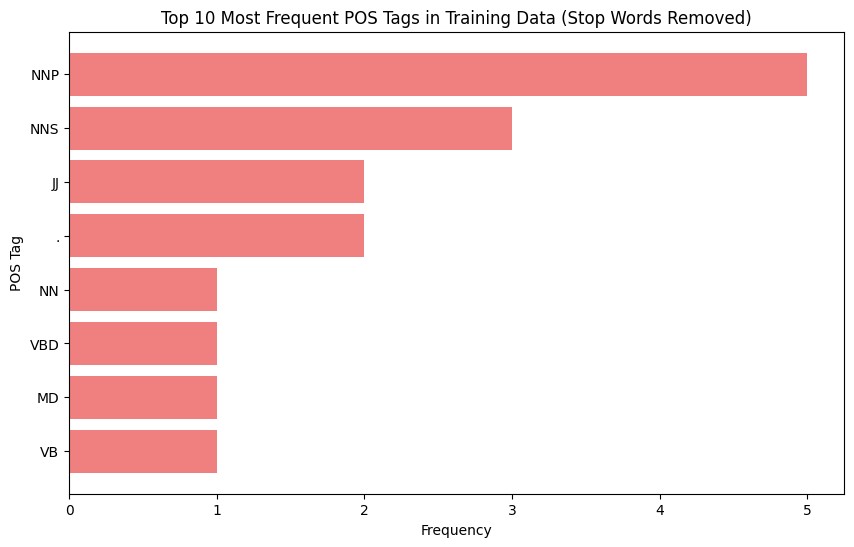

In [10]:
# Visualizing POS tag frequencies
nltk.download('stopwords', quiet=True)

# Get the set of English stop words for efficient lookup
stop_words_set = set(stopwords.words('english'))

all_individual_pos_tags = []

# Iterate through each text in X_train to extract POS tags
# X_train is assumed to be a list of strings (sentences) from previous cells.
for text_content in X_train:
    tokens = nltk.word_tokenize(text_content) # Split text into words
    
    # Filter out stop words. Comparison is case-insensitive.
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words_set]

    # If the sentence becomes empty after stop word removal (e.g., all tokens were stop words),
    # or if the original sentence was empty, skip to the next sentence.
    if not filtered_tokens:
        continue
        
    # Perform Part-of-Speech tagging on the filtered tokens.
    # This returns a list of (token, TAG) tuples, e.g., [('cat', 'NN'), ('sat', 'VBD')]
    pos_tagged_tokens = nltk.pos_tag(filtered_tokens) 

    # Extract and store only the POS tags (the TAG part)
    for _, tag in pos_tagged_tokens: # We only need the tag, not the token itself for this visualization
        all_individual_pos_tags.append(tag)

# Count the frequencies of all collected individual POS tags
pos_tag_counter = Counter(all_individual_pos_tags)

# Get the 10 most common POS tags and their counts (or all if fewer than 10)
top_10_pos_tags = pos_tag_counter.most_common(10)

# Check if any POS tags were found before attempting to plot
if top_10_pos_tags:
    # Unzip the list of (tag, count) tuples into two separate lists
    tags, counts = zip(*top_10_pos_tags)

    plt.figure(figsize=(10,6)) # plt is assumed to be imported as matplotlib.pyplot
    # Create a horizontal bar chart; convert tuples from zip to lists for plotting
    plt.barh(list(tags), list(counts), color='lightcoral')
    plt.xlabel('Frequency')
    plt.ylabel('POS Tag')
    plt.title('Top 10 Most Frequent POS Tags in Training Data (Stop Words Removed)')
    plt.gca().invert_yaxis() # Invert y-axis to show the most frequent item at the top
    plt.show()
else:
    # This message is displayed if X_train was empty, all tokens were stop words,
    # or no tokens remained after filtering to be tagged.
    print("No POS tags found to display. Check X_train data and stop word filtering process.")

## Implementing Text Classification Models
Implementing text classification models allows us to categorize textual data effectively, such as sentiment analysis or topic classification. Using scikit-learn, we can employ popular algorithms including Naive Bayes, Support Vector Machines (SVM), and logistic regression to accurately predict categories based on textual input.

### Getting ready
We'll begin by preparing our environment and data for classification modeling.


In [11]:
# Load the libraries
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import nltk
from nltk.corpus import brown
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report 

# Download NLTK resources (if not already downloaded)
# It's good practice to include this, though in a real notebook,
# it might be run once in a separate cell.
try:
    nltk.data.find('corpora/brown.zip')
except nltk.downloader.DownloadError:
    nltk.download('brown', quiet=True)
try:
    # Punkt is a tokenizer dependency for some NLTK corpus operations.
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt', quiet=True)

# Load the dataset from NLTK Brown corpus
document_ids = brown.fileids()
texts = [' '.join(brown.words(file_id)) for file_id in document_ids]
# Each document in Brown corpus is assigned to a category (genre).
# We use the first category as the label.
raw_labels = [brown.categories(file_id)[0] for file_id in document_ids]

# Convert string labels (categories) to numerical labels for scikit-learn
unique_raw_labels = sorted(list(set(raw_labels)))
label_to_int_mapping = {label: i for i, label in enumerate(unique_raw_labels)}
labels = [label_to_int_mapping[label] for label in raw_labels]

# Split the data
# The Brown corpus has 500 documents and 15 categories.
# The minimum number of samples per category is >20, so stratify will work fine.
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.5, stratify=labels, random_state=2024)


### How to do it...
We'll transform the textual data and train three different classification models.


In [12]:
# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Train a Naive Bayes model
nb_clf = MultinomialNB()
nb_clf.fit(X_train_vect, y_train)

# Train an SVM model
svm_clf = SVC(random_state=2024)
svm_clf.fit(X_train_vect, y_train)

# Train a logistic regression model
lr_clf = LogisticRegression(random_state=2024, max_iter=1000)
lr_clf.fit(X_train_vect, y_train)

# Evaluate the models
models = {'Naive Bayes': nb_clf, 'SVM': svm_clf, 'Logistic Regression': lr_clf}
for name, model in models.items():
    y_pred = model.predict(X_test_vect)
    print(f'{name} Classification Report:')
    # Generate classification report as a dictionary
    # Utilize unique_raw_labels for target_names to show actual class names
    report_dict = classification_report(y_test, y_pred, target_names=unique_raw_labels, output_dict=True, zero_division=0)
    # Convert to DataFrame
    report_df = pd.DataFrame(report_dict).transpose()
    
    # Stylize the DataFrame
    styled_df = (report_df
        .style
        .background_gradient(cmap='Blues', subset=['precision', 'recall', 'f1-score'])
        .format({
            'precision': '{:.3f}',
            'recall': '{:.3f}', 
            'f1-score': '{:.3f}',
            'support': '{:.0f}'
        })
    )
    display(styled_df)
    print("\n")

Naive Bayes Classification Report:


,precision,recall,f1-score,support
adventure,0.000,0.000,0.000,15
belles_lettres,0.173,1.000,0.295,37
editorial,0.000,0.000,0.000,14
fiction,0.000,0.000,0.000,14
government,0.000,0.000,0.000,15
hobbies,0.000,0.000,0.000,18
humor,0.000,0.000,0.000,4
learned,0.556,0.500,0.526,40
lore,0.000,0.000,0.000,24
mystery,0.000,0.000,0.000,12




SVM Classification Report:


,precision,recall,f1-score,support
adventure,0.400,0.133,0.200,15
belles_lettres,0.236,0.946,0.378,37
editorial,0.000,0.000,0.000,14
fiction,0.312,0.357,0.333,14
government,0.000,0.000,0.000,15
hobbies,0.000,0.000,0.000,18
humor,0.000,0.000,0.000,4
learned,0.424,0.700,0.528,40
lore,0.000,0.000,0.000,24
mystery,0.000,0.000,0.000,12




Logistic Regression Classification Report:


,precision,recall,f1-score,support
adventure,1.000,0.067,0.125,15
belles_lettres,0.231,0.919,0.370,37
editorial,0.000,0.000,0.000,14
fiction,0.000,0.000,0.000,14
government,0.000,0.000,0.000,15
hobbies,1.000,0.056,0.105,18
humor,0.000,0.000,0.000,4
learned,0.377,0.725,0.496,40
lore,0.000,0.000,0.000,24
mystery,0.000,0.000,0.000,12


### How it works...
We’ve explored some of these models previously and as you can see, once our text is preprocessed, they work well in this context, too.
- **Naive Bayes** performs well on text data due to its probabilistic nature and efficiency in handling large feature spaces.
- **SVM** excels at capturing complex relationships by finding optimal hyperplanes to separate classes.
- **Logistic regression** provides robust predictions and interpretable probabilities, making it useful for binary classification tasks.


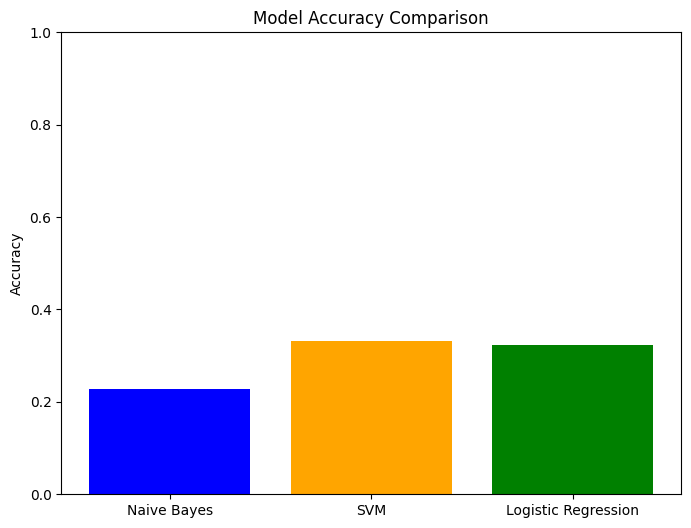

In [13]:
# Visualizing classification accuracies
model_accuracies = {}
for model_name, model_instance in models.items():
    y_pred = model_instance.predict(X_test_vect)
    # Using parameters consistent with the report generation in the preceding cells.
    # Assumes unique_raw_labels is defined and available from a previous cell,
    # as it was used in file_context_0 for generating classification reports.
    # The target_names parameter does not affect the overall 'accuracy' value but is included for consistency.
    report_dict = classification_report(y_test, y_pred, target_names=unique_raw_labels, output_dict=True, zero_division=0)
    model_accuracies[model_name] = report_dict['accuracy']

plt.figure(figsize=(8,6))

# Plotting using the calculated accuracies
# .keys() and .values() from the same dictionary will be in corresponding orders.
plt.bar(model_accuracies.keys(), model_accuracies.values(), color=['blue', 'orange', 'green'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.show()


## Multiclass Classification Strategies
Multiclass classification, like we saw previously in Chapter 6, involves predicting categories when there are more than two classes. Various strategies such as one-vs-rest, one-vs-one, and hierarchical classification help effectively tackle these problems. Using scikit-learn, we can implement and explore these approaches for text classification tasks.

### Getting ready
We'll set up our environment and dataset to implement multiclass classification strategies.


In [14]:
# Load the libraries
import nltk
from nltk.corpus import brown # Changed from webtext to brown
from sklearn.model_selection import train_test_split # Ensure this is available

# Download the NLTK brown corpus if not already present
# Using quiet=True to suppress verbose download output in the notebook
try:
    _ = brown.fileids() # Check if already downloaded and accessible
except LookupError:
    nltk.download('brown', quiet=True)
except Exception: # Catch other potential NLTK setup issues
    nltk.download('brown', quiet=True)

# Load the dataset from NLTK brown corpus
file_ids = brown.fileids()
texts = [brown.raw(file_id) for file_id in file_ids]
# Use the genre of the file as its label. Each file in Brown belongs to one genre.
labels = [brown.categories(file_id)[0] for file_id in file_ids]

# Split the data
# The Brown corpus has 500 documents.
# A test_size of 0.3 will result in 350 train and 150 test samples.
# This provides significantly more samples than the previous 3 train/3 test.
# Added stratify=labels for better class distribution in splits.
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.3, random_state=2024, stratify=labels)


### How to do it...
We will demonstrate two primary strategies: one-vs-rest and one-vs-one classification.

In [15]:
# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Implement One-vs-Rest classification
ovr_clf = OneVsRestClassifier(LogisticRegression(random_state=2024, solver='liblinear'))
ovr_clf.fit(X_train_vect, y_train)
y_pred_ovr = ovr_clf.predict(X_test_vect)

# Implement One-vs-One classification
ovo_clf = OneVsOneClassifier(LogisticRegression(random_state=2024, solver='liblinear'))
ovo_clf.fit(X_train_vect, y_train)
y_pred_ovo = ovo_clf.predict(X_test_vect)

# Evaluate the classifiers
# Added zero_division=0 to handle cases where precision/recall might be ill-defined
# due to no predicted samples or no true samples for a class.

print('One-vs-Rest Classification Report:')
report_ovr_dict = classification_report(y_test, y_pred_ovr, zero_division=0, output_dict=True)
report_ovr_df = pd.DataFrame(report_ovr_dict).transpose()
styled_ovr_df = (report_ovr_df
    .style
    .background_gradient(cmap='Blues', subset=['precision', 'recall', 'f1-score'])
    .format({
        'precision': '{:.3f}',
        'recall': '{:.3f}', 
        'f1-score': '{:.3f}',
        'support': '{:.0f}'
    })
)
display(styled_ovr_df)
print("\n")

print('One-vs-One Classification Report:')
report_ovo_dict = classification_report(y_test, y_pred_ovo, zero_division=0, output_dict=True)
report_ovo_df = pd.DataFrame(report_ovo_dict).transpose()
styled_ovo_df = (report_ovo_df
    .style
    .background_gradient(cmap='Blues', subset=['precision', 'recall', 'f1-score'])
    .format({
        'precision': '{:.3f}',
        'recall': '{:.3f}', 
        'f1-score': '{:.3f}',
        'support': '{:.0f}'
    })
)
display(styled_ovo_df)
print("\n")


One-vs-Rest Classification Report:


,precision,recall,f1-score,support
adventure,0.000,0.000,0.000,9
belles_lettres,0.224,0.773,0.347,22
editorial,0.000,0.000,0.000,8
fiction,0.000,0.000,0.000,9
government,0.000,0.000,0.000,9
hobbies,0.000,0.000,0.000,11
humor,0.000,0.000,0.000,3
learned,0.345,0.792,0.481,24
lore,0.000,0.000,0.000,14
mystery,0.000,0.000,0.000,7




One-vs-One Classification Report:


,precision,recall,f1-score,support
adventure,0.000,0.000,0.000,9
belles_lettres,0.185,0.773,0.298,22
editorial,0.000,0.000,0.000,8
fiction,0.000,0.000,0.000,9
government,0.000,0.000,0.000,9
hobbies,0.000,0.000,0.000,11
humor,0.000,0.000,0.000,3
learned,0.373,0.792,0.507,24
lore,0.000,0.000,0.000,14
mystery,0.000,0.000,0.000,7


### How it works...
As a refresher from Chapter 6, here are two of the techniques we utilized for classification problems featuring more than one class.
- **One-vs-Rest (OvR)**: Builds one classifier per class, distinguishing one class from all other classes. This strategy is computationally efficient and straightforward.
- **One-vs-One (OvO)**: Constructs classifiers for every pair of classes, resulting in a higher number of models, but often providing better performance on balanced datasets.


## Evaluating Text Models
Evaluating text models involves using metrics specifically tailored to assess the performance of text classification tasks. Metrics such as precision, recall, F1 score, and confusion matrices provide detailed insights into how accurately and effectively our models classify textual data, allowing us to interpret and improve model outcomes. However, although it falls outside the scope of this book, LLMs require far more complex techniques to evaluate their performance, especially when generating text rather than using it in more simplistic ML problems like classification. 

### Getting ready
Let's set up the necessary libraries and dataset for evaluating text classification models.


In [16]:
# Load the libraries
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import movie_reviews
import random

# Download NLTK data (movie_reviews corpus) if not already downloaded
try:
    # Check if the corpus is accessible
    movie_reviews.categories()
except LookupError:
    nltk.download('movie_reviews')

# Load the dataset from NLTK movie_reviews corpus
documents = []
for category in movie_reviews.categories():
    for fileid in movie_reviews.fileids(category):
        documents.append((list(movie_reviews.words(fileid)), category))

# Shuffle the documents for better splitting.
# Using a fixed seed for reproducibility, consistent with random_state in train_test_split.
random.seed(2024)
random.shuffle(documents)

# Prepare texts (joining words into strings) and labels
texts = [" ".join(words) for words, category in documents]
labels = [category for words, category in documents]

# Split the data
# Kept test_size and random_state as in the original selection
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.5, random_state=2024)


### How to do it...
We'll use logistic regression as an example to demonstrate evaluating text models.


Precision: 0.8034174884733607
Recall: 0.803
F1 Score: 0.8029765558512367

Classification Report:


,precision,recall,f1-score,support
neg,0.791016,0.818182,0.804369,495.000000
pos,0.815574,0.788119,0.801611,505.000000
accuracy,0.803000,0.803000,0.803000,0.803000
macro avg,0.803295,0.803150,0.802990,1000.000000
weighted avg,0.803417,0.803000,0.802977,1000.000000


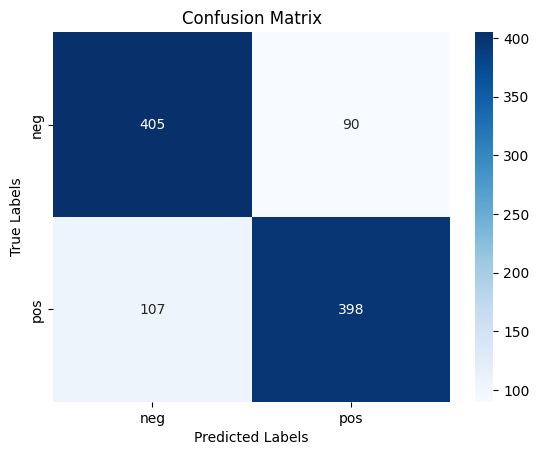

In [ ]:
# Vectorize text using TF-IDF
vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Train a logistic regression classifier
clf = LogisticRegression(random_state=2024)
clf.fit(X_train_vect, y_train)

# Make predictions
y_pred = clf.predict(X_test_vect)

# Evaluate the model
print("Precision:", precision_score(y_test, y_pred, average='weighted', zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='weighted', zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted', zero_division=0))

# Generate classification report as a styled DataFrame
report_dict = classification_report(y_test, y_pred, labels=clf.classes_, target_names=clf.classes_, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report_dict).transpose()

print("\nClassification Report:")
display(report_df.style.set_caption("Classification Report"))

# Generate and visualize a confusion matrix
# The confusion_matrix function computes class-wise accuracy.
# labels=clf.classes_ ensures the matrix rows/columns follow a consistent order.
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=clf.classes_, yticklabels=clf.classes_, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### How it works...
- **Precision** measures the accuracy of positive predictions.
- **Recall (sensitivity)** assesses the ability to identify positive instances.
- **F1-score** provides a balanced measure by combining precision and recall.
- **Confusion matrices** visually represent the accuracy of predictions for each class, helping us easily identify misclassifications.


## Practical Exercises with Text Processing
In this final section, we will engage in practical exercises involving preprocessing text data, vectorizing it, extracting meaningful features, and building multiclass classification models. These exercises are designed to reinforce the concepts learned throughout the chapter and demonstrate how to effectively apply text processing and classification techniques in various scenarios. By the end of this section, we will have hands-on experience to apply in our own machine learning projects.

### Exercise 1: Preprocessing and Vectorizing Text
In this exercise, we’ll preprocess raw text data and transform it into numerical features using vectorization techniques.


In [43]:
# Load libraries
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the Dataset
texts = [
    "Data preprocessing is essential.",
    "Vectorization transforms text.",
    "Clean data improves model performance.",
    "Machine learning algorithms use numerical data."
]

# Preprocess the Data (basic cleaning)
texts_cleaned = [text.lower() for text in texts]

# Vectorize the Text
vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(texts_cleaned)


### Exercise 2: Feature Extraction with N-grams
In this exercise, we'll extract n-gram features from text to capture context better for classification tasks.


In [44]:
# Load libraries
from sklearn.feature_extraction.text import CountVectorizer

# Load the Dataset
texts = [
    "Feature extraction is crucial.",
    "N-grams capture context.",
    "Models benefit from good features.",
    "Contextual information enhances classification."
]

# Extract N-gram Features
ngram_vectorizer = CountVectorizer(ngram_range=(1,2))
X_train_ngram = ngram_vectorizer.fit_transform(texts)


### Exercise 3: Building and Evaluating a Multiclass Classifier
Here, we will build, train, and evaluate a multiclass classifier using logistic regression.


In [ ]:
# Load libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Load the Dataset
texts = [
    "This is an economic news article.",
    "Sports events are exciting.",
    "Technology advances rapidly.",
    "Politics affect global relations."
]
labels = ["Economy", "Sports", "Technology", "Politics"]

# Vectorize Text
vectorizer = TfidfVectorizer()
X_vect = vectorizer.fit_transform(texts)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_vect, labels, test_size=0.5, random_state=2024)

# Train the Classifier
clf = LogisticRegression(random_state=2024)
clf.fit(X_train, y_train)
6.	Make Predictions and Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
